In [16]:
import pandas as pd
import numpy as np
import os
from sklearn import metrics

import sys
sys.path.append("../src")
from plotting import hit_enrichment

DATAPATH ="../data"
SMILES = "CAN_SMILES"

In [3]:
assays = ['nf54','k1', 'mtb', 'cho', 'hepg2','clintH', 'clintM', 'clintR', 'caco', 'sol', 
          'herg', "cyp2c9", "cyp2c19", 'cyp3a4', 'cyp2d6',]

In [4]:
assays_fold5 =  {
        "nf54":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","nf54_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_nf54_test_5.csv"))],
        "k1":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","k1_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_k1_test_5.csv"))],
        "pi4kb":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","pi4kb_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_pi4kb_test_5.csv"))],
        "mtb":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","mtb_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_mtb_test_5.csv"))],
        "cho":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","cho_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_cho_test_5.csv"))],
        "hepg2":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","hepg2_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_hepg2_test_5.csv"))],
        "clintH":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","clintH_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_clintH_test_5.csv"))],
        "clintM": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","clintM_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_clintM_test_5.csv"))],
        "clintR": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","clintR_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_clintR_test_5.csv"))],
        "caco":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","caco_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_caco_test_5.csv"))],
        "sol":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","sol_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_sol_test_5.csv"))],
        "cyp3a4":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets","cyp3a4.csv")), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "full","output_cyp3a4_subset.csv"))],
        "cyp2d6":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets","cyp2d6.csv")), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "full","output_cyp2d6_subset.csv"))],
        "cyp2c9":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets","cyp2c9.csv")), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "full","output_cyp2c9_subset.csv"))],
        "cyp2c19":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets","cyp2c19.csv")), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "full","output_cyp2c19_subset.csv"))],
        "herg":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets", "herg.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "eos_models", "herg_eos2ta5.csv"))]
        }
#rename herg so it has same output column name
assays_fold5["herg"][1].rename(columns={"probability":"clf_ex1"}, inplace=True)

In [11]:
# Table 1: Total molecules in each assay
total_mols = {}
for a in assays:
    if a == "herg":
        n_mols =  12620 #from publication
        total_mols[a] = n_mols
    elif "cyp" in a:
        df = pd.read_csv(os.path.join(DATAPATH, "external", "processed", "cyp_all_{}.csv".format(a)))
        n_mols = len(df)
        total_mols[a] = n_mols
    else:
        df = pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets", "{}.csv".format(a)))
        n_mols = len(df)
        total_mols[a] = n_mols
print(total_mols)

{'nf54': 3289, 'k1': 1425, 'mtb': 3244, 'cho': 2029, 'hepg2': 1457, 'clintH': 1430, 'clintM': 1165, 'clintR': 1202, 'caco': 134, 'sol': 3227, 'herg': 12620, 'cyp2c9': 16379, 'cyp2c19': 15511, 'cyp3a4': 21810, 'cyp2d6': 17812}


In [43]:
# Table 2: AUROCS 
all_aucs = {}
for a in assays:
    if a == "herg":
        assay = "herg"
        probacol = "probability"
        model_io = {
            "fold1": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_1.csv".format(assay))), 
                    pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models", "eos2ta5_{0}_train_1.csv".format(assay)))],
            "fold2": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_2.csv".format(assay))), 
                    pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models","eos2ta5_{0}_train_2.csv".format(assay)))],
            "fold3": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_3.csv".format(assay))), 
                    pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models","eos2ta5_{0}_train_3.csv".format(assay)))],
            "fold4": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_4.csv".format(assay))), 
                    pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models","eos2ta5_{0}_train_4.csv".format(assay)))],
            "fold5": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_5.csv".format(assay))), 
                    pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models","eos2ta5_{0}_train_5.csv".format(assay)))],
            }
    elif "cyp" in a:
        assay = a
        probacol = "clf_ex1"
        model_io = {
        "fold1": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_1.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_1.csv".format(assay)))],
        "fold2": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_2.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_2.csv".format(assay)))],
        "fold3": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_3.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_3.csv".format(assay)))],
        "fold4": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_4.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_4.csv".format(assay)))],
        "fold5": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_5.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_5.csv".format(assay)))],
        }
    else:
        assay = a
        probacol="clf_ex1"
        model_io = {
        "fold1": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_1.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_1.csv".format(assay)))],
        "fold2": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_2.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_2.csv".format(assay)))],
        "fold3": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_3.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_3.csv".format(assay)))],
        "fold4": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_4.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_4.csv".format(assay)))],
        "fold5": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_5.csv".format(assay))), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_5.csv".format(assay)))],
        }

    #interpolate roc curves from the random split folds
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for k,v in model_io.items():
        yt = v[0]["bin"]
        proba1 = v[1][probacol]
        fpr, tpr, _ = metrics.roc_curve(yt, proba1)
        roc_auc = metrics.roc_auc_score(yt, proba1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    all_aucs[a] = [np.round(mean_auc, 3), np.round(std_auc,3)]

print(all_aucs)


{'nf54': [0.915, 0.02], 'k1': [0.853, 0.022], 'mtb': [0.901, 0.036], 'cho': [0.845, 0.032], 'hepg2': [0.973, 0.01], 'clintH': [0.794, 0.027], 'clintM': [0.782, 0.056], 'clintR': [0.79, 0.033], 'caco': [0.951, 0.042], 'sol': [0.888, 0.019], 'herg': [0.852, 0.014], 'cyp2c9': [0.761, 0.035], 'cyp2c19': [0.542, 0.035], 'cyp3a4': [0.715, 0.07], 'cyp2d6': [0.681, 0.035]}


In [21]:
assays_fold5["nf54"][1].head()

,compound_id,smiles,clf_ex1,clf_ex1_bin
0,CID120,Cn1c(N2CCNCC2)nc2ccccc21,0.064630,0.0
1,CID273,CCOC(=O)C12CCCN(C(=O)OCc3ccccc3)CC1CN(Cc1ccccc...,0.066616,0.0
2,CID265,CS(=O)(=O)c1ccc(-c2cnn3c2NC(c2cccc(S(=O)(=O)C4...,0.621649,1.0
3,CID190,NC(=O)c1cccc(-c2nc3c(NCCNc4ccccn4)nccc3[nH]2)c1,0.402024,0.0
4,CID016,COc1ccc(-c2cc(-c3ccc(S(C)(=O)=O)cc3)cnc2NCCCCN...,0.236036,0.0


In [44]:
# Table 3 Hit enrichments
hit_enr = {}
perc_only = {}
for a in assays:
    v = assays_fold5[a]
    v[1]["bin"] = v[0]["bin"] #add real outcome binarized
    if len(v[1])>= 50:
        pos_prop = len(v[1][v[1]["bin"]==1])/len(v[1])
        total_pos = int(50*pos_prop)
        idxs = [int(x) for x in np.linspace(0,49,total_pos)]
        x = np.zeros(50)
        x[idxs] = 1
        random = x.tolist()
        random_pos = np.sum(random)

        neg_prop = len(v[1][v[1]["bin"]==0])/len(v[1])
        total_neg = int(50*neg_prop)
        idxs = [int(x) for x in np.linspace(0,49,total_neg)]
        x = np.zeros(50)
        x[idxs] = 1
        random = x.tolist()
        random_neg = np.sum(random)

        ranked_top = v[1].sort_values("clf_ex1")[-50:]
        top_pos = np.sum(ranked_top["bin"].tolist())

        ranked_bot = v[1].sort_values("clf_ex1", ascending=False)[-50:]
        bot_pos = np.sum(ranked_bot["bin"].tolist())
        bot_neg = 50-bot_pos

        top_enr_perc = (top_pos) - (random_pos) / 50
        bot_enr_perc = (bot_neg) - (random_neg) / 50

        hit_enr[a] = [random_pos, top_pos, bot_pos, top_enr_perc, random_neg, bot_neg,  bot_enr_perc]
        perc_only[a] = [ top_enr_perc,bot_enr_perc]

    

In [46]:
hit_enr

{'nf54': [10.0, 42, 0, 41.8, 39.0, 50, 49.22],
 'k1': [11.0, 24, 2, 23.78, 38.0, 48, 47.24],
 'mtb': [8.0, 38, 2, 37.84, 41.0, 48, 47.18],
 'cho': [8.0, 23, 0, 22.84, 41.0, 50, 49.18],
 'hepg2': [20.0, 48, 0, 47.6, 29.0, 50, 49.42],
 'clintH': [25.0, 43, 10, 42.5, 24.0, 40, 39.52],
 'clintM': [30.0, 38, 20, 37.4, 19.0, 30, 29.62],
 'clintR': [29.0, 41, 14, 40.42, 20.0, 36, 35.6],
 'sol': [27.0, 50, 2, 49.46, 22.0, 48, 47.56],
 'herg': [32.0, 46, 10, 45.36, 17.0, 40, 39.66],
 'cyp2c9': [9.0, 11, 6, 10.82, 40.0, 44, 43.2],
 'cyp2c19': [12.0, 13, 13, 12.76, 37.0, 37, 36.26],
 'cyp3a4': [8.0, 10, 5, 9.84, 41.0, 45, 44.18],
 'cyp2d6': [8.0, 10, 7, 9.84, 41.0, 43, 42.18]}

In [45]:
perc_only

{'nf54': [41.8, 49.22],
 'k1': [23.78, 47.24],
 'mtb': [37.84, 47.18],
 'cho': [22.84, 49.18],
 'hepg2': [47.6, 49.42],
 'clintH': [42.5, 39.52],
 'clintM': [37.4, 29.62],
 'clintR': [40.42, 35.6],
 'sol': [49.46, 47.56],
 'herg': [45.36, 39.66],
 'cyp2c9': [10.82, 43.2],
 'cyp2c19': [12.76, 36.26],
 'cyp3a4': [9.84, 44.18],
 'cyp2d6': [9.84, 42.18]}

In [14]:
# Hit enrichments over 100 molecules for text
hit_enr = {}
perc_only = {}
for a in ["nf54", "mtb"]:
    v = assays_fold5[a]
    v[1]["bin"] = v[0]["bin"] #add real outcome binarized
    print(len(v[1]))
    tenperc = round(len(v[1])*10/100)
    print(tenperc)
    pos_prop = len(v[1][v[1]["bin"]==1])/len(v[1])
    total_pos = int(tenperc*pos_prop)
    idxs = [int(x) for x in np.linspace(0,tenperc-1,total_pos)]
    x = np.zeros(tenperc)
    x[idxs] = 1
    random = x.tolist()
    random_pos = np.sum(random)

    neg_prop = len(v[1][v[1]["bin"]==0])/len(v[1])
    total_neg = int(tenperc*neg_prop)
    idxs = [int(x) for x in np.linspace(0,tenperc-1,total_neg)]
    x = np.zeros(tenperc)
    x[idxs] = 1
    random = x.tolist()
    random_neg = np.sum(random)

    ranked_top = v[1].sort_values("clf_ex1")[-(tenperc):]
    top_pos = np.sum(ranked_top["bin"].tolist())

    ranked_bot = v[1].sort_values("clf_ex1", ascending=False)[-(tenperc):]
    bot_pos = np.sum(ranked_bot["bin"].tolist())
    bot_neg = tenperc-bot_pos

    top_enr_perc = (top_pos) - (random_pos) / tenperc
    bot_enr_perc = (bot_neg) - (random_neg) / tenperc

    hit_enr[a] = [random_pos, top_pos, bot_pos, top_enr_perc, random_neg, bot_neg,  bot_enr_perc]
    perc_only[a] = [ top_enr_perc,bot_enr_perc]

329
33
325
32


In [15]:
hit_enr

{'nf54': [7.0, 30, 0, 29.78787878787879, 25.0, 33, 32.24242424242424],
 'mtb': [5.0, 26, 1, 25.84375, 26.0, 31, 30.1875]}

In [21]:
# EOS2GTH (MAIP Malaria surrogate)
from sklearn import metrics
preds= pd.read_csv(os.path.join(DATAPATH, "predictions", "eos_models","nf54_eos2gth.csv"))
real = pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets", "nf54.csv"))

In [27]:
yt = real["bin"]
yp = preds["score"]

fpr, tpr, _ = metrics.roc_curve(yt, yp)
auroc = metrics.roc_auc_score(yt, yp)
print(auroc)

0.7397554776201356


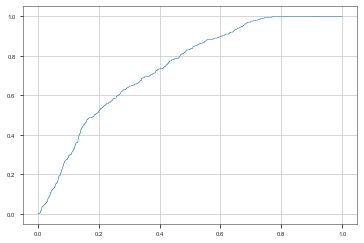

In [26]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)